In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import glob
import cv2
from tqdm import tqdm
from IPython import display
import time
import warnings
warnings.filterwarnings('ignore')


from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten


from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [2]:
trainpath = '/kaggle/input/fashion-product-images-small/images'

In [3]:
image_size=28  
X_train = []


files = glob.glob(os.path.join(trainpath,'*.jpg'))   
for file in files: 
    orignal_image = cv2.imread(file)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    resized_image = cv2.resize(image , (image_size,image_size))
    X_train.append(resized_image)

In [4]:
len(X_train)

44441

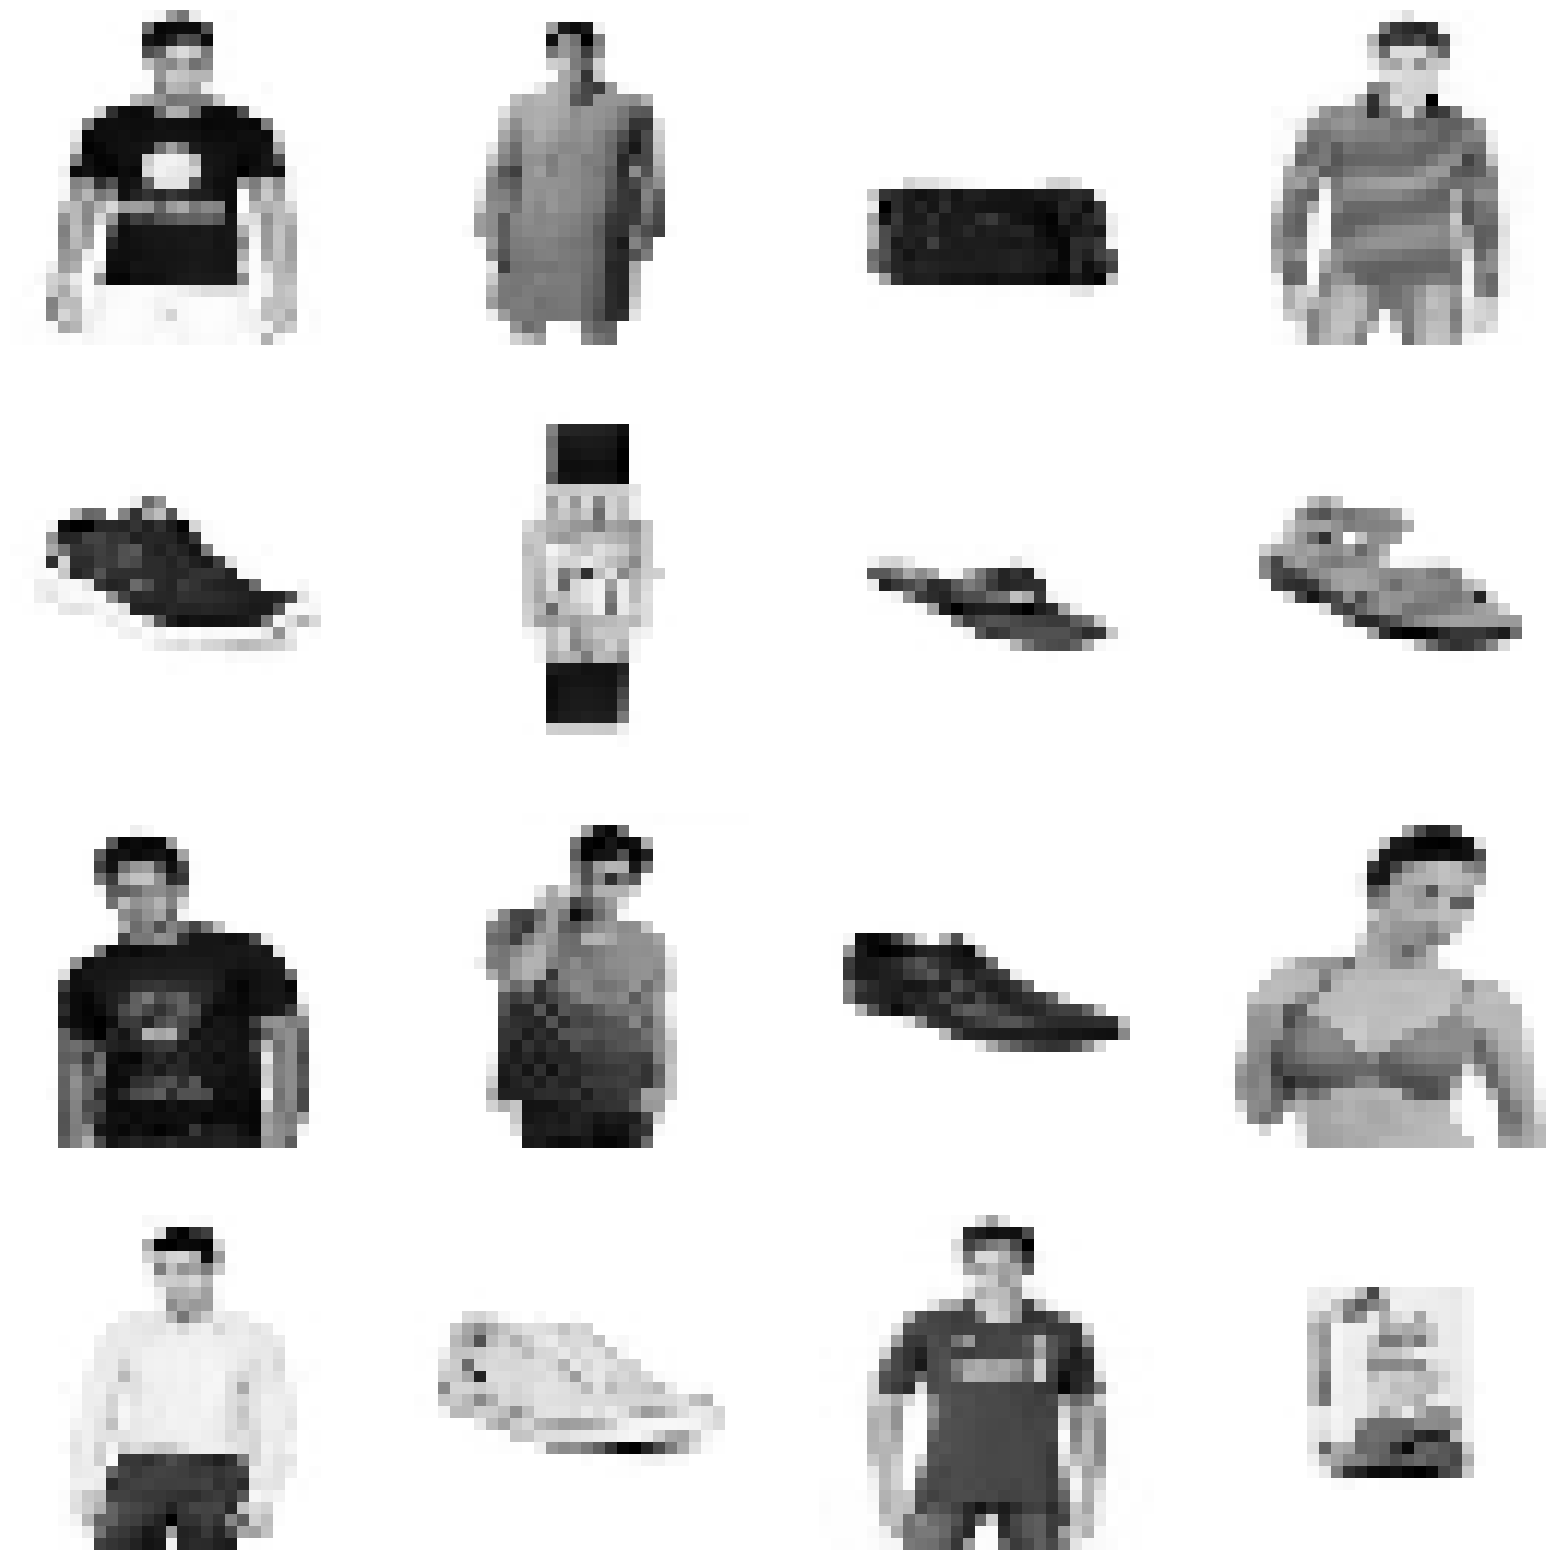

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train ),16))) : 
    plt.subplot(4,4,n+1)
    plt.imshow(X_train [i],cmap='gray')   
    plt.axis('off')

In [6]:
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(28*28*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_size, image_size, 4)))
    assert model.output_shape == (None, image_size, image_size, 4)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, image_size, image_size, 1)

    return model

In [9]:
generator = generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3136)                │         313,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3136)                │          12,544 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 28, 28, 64)          │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,928 (1.47 MB)

 Trainable params: 378,464 (1.44 MB)

 Non-trainable params: 6,464 (25.25 KB)

In [10]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[image_size,image_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(1,activation = 'sigmoid'))

    return model

In [11]:
discriminator = discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,385 (1.04 MB)

 Trainable params: 272,385 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [13]:
checkpoint_dir = './training_checkpoints'    # to save the model through training
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
EPOCHS = 500
noise_dim = 100
BATCH_SIZE = 128

In [18]:
@tf.function
def train_step(images,BATCH_SIZE):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss , disc_loss

In [19]:
def train(dataset, epochs,BATCH_SIZE):
    loss_gen = []
    loss_disc = []
    for epoch in tqdm(range(epochs)):
        L1,L2 =0,0
        for image_batch in dataset:
            Ln1 , Ln2 = train_step(image_batch,BATCH_SIZE)
            L1 = L1  +Ln1
            L2 = L2  +Ln2
        loss_gen.append(L1)
        loss_disc.append(L2)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)



    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)
    return loss_gen,loss_disc

In [20]:
num_examples_to_generate = 8
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(6, 6, i+1)
        plt.imshow(predictions[i, :, :, :] * 255.0, cmap='gray') 
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

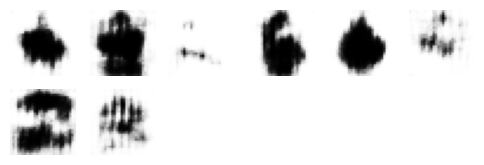

In [21]:
History_gen,History_disc = train(dataset=train_dataset, epochs = EPOCHS,BATCH_SIZE=BATCH_SIZE)